# Revisit CO2e Estimates
This repeats the "manual decision tree" methodology used in notebook 05, but with two changes to data aggregation:
1. fixes a mistake where CA and CT capacity factors were simply averaged together instead of weighted by energy.
2. interprets the marginal build of the ISO queue as plants instead of generators. I'm not sure this is correct for GTs, but is certainly true for CCs.

The primary impact of these changes was to increase CC cap factor from 0.52 to 0.62, a nearly 20% increase in CO2e.  Small GTs also saw a large increase, from 0.44 to 0.6, a 33% increase in CO2e. Large GTs were about the same.

In [1]:
import pandas as pd
import sqlalchemy as sa
import numpy as np

In [2]:
from dbcp.helpers import download_pudl_data, get_sql_engine

/app/.local/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
pudl_data_path = download_pudl_data()
pudl_engine = sa.create_engine(
    f"sqlite:////{pudl_data_path}/pudl_data/sqlite/pudl.sqlite"
)

In [35]:
query = """
with
plants as (
    select
        plant_id_eia,
        CASE prime_mover_code
            WHEN 'CA' THEN 'CC'
            WHEN 'CT' THEN 'CC'
            ELSE prime_mover_code
        END as mod_prime_mover,
        sum(fuel_consumed_for_electricity_mmbtu) as mmbtu,
        sum(net_generation_mwh) as mwh
    from generation_fuel_eia923
    where report_date >= date('2020-01-01') -- this is monthly data
    AND fuel_type_code_pudl = 'gas'
    AND prime_mover_code in ('CA', 'CT', 'CS', 'GT')
    group by 1,2
),
gen_cap as (
    select
        plant_id_eia,
        generator_id,
        report_date,
        capacity_mw
    from generators_eia860
    where report_date = date('2020-01-01') -- annual data
    AND fuel_type_code_pudl = 'gas'
    AND operational_status = 'existing'
),
gens as (
    select
        cap.*,
        CASE prime_mover_code
            WHEN 'CA' THEN 'CC'
            WHEN 'CT' THEN 'CC'
            ELSE prime_mover_code
        END as mod_prime_mover
    from gen_cap as cap
    INNER JOIN generators_entity_eia as ent
    on cap.plant_id_eia = ent.plant_id_eia
    and cap.generator_id = ent.generator_id
    where ent.operating_date >= date('2015-01-01')
),
agg_gens as (
    select
        plant_id_eia,
        mod_prime_mover,
        sum(capacity_mw) as mw
    from gens
    group by 1, 2
)
select
    plants.*,
    agg.mw,
    plants.mwh / agg.mw / 8784.0 as cap_factor,
    mmbtu / mwh as heat_rate
from agg_gens as agg
inner join plants
on plants.plant_id_eia = agg.plant_id_eia
and plants.mod_prime_mover = agg.mod_prime_mover
;
"""
plant = pd.read_sql(query, pudl_engine)

In [36]:
plant

,plant_id_eia,mod_prime_mover,mmbtu,mwh,mw,cap_factor,heat_rate
0,116,GT,7370739.0,740914.000,809.5,0.104198,9.948171
1,165,CC,16964140.0,2452600.000,600.3,0.465121,6.916798
2,404,CC,9962119.0,1369374.000,335.8,0.464247,7.274944
3,404,GT,1270722.0,130703.000,213.8,0.069596,9.722210
4,422,CC,284639.0,33257.000,87.0,0.043518,8.558770
...,...,...,...,...,...,...,...
146,63285,GT,2130307.0,227758.000,33.5,0.773992,9.353379
147,63347,GT,657196.0,56628.384,7.5,0.859569,11.605417
148,63423,GT,520501.0,55156.000,16.5,0.380554,9.436888
149,63632,GT,3705842.0,328991.000,61.4,0.609991,11.264266


In [37]:
plant.describe()

,plant_id_eia,mmbtu,mwh,mw,cap_factor,heat_rate
count,151.000000,1.510000e+02,1.510000e+02,151.000000,151.000000,150.000000
mean,45835.503311,1.379265e+07,1.942106e+06,409.725166,0.533121,8.880403
std,23687.294895,1.824337e+07,2.687873e+06,457.455936,0.439637,3.077642
min,116.000000,0.000000e+00,0.000000e+00,0.500000,0.000000,4.014125
25%,50215.000000,4.553225e+05,4.660800e+04,24.200000,0.175921,6.786192
50%,58284.000000,3.461605e+06,3.478270e+05,151.700000,0.593177,7.385890
75%,60351.000000,2.463247e+07,3.643579e+06,752.500000,0.725392,11.049314
max,64020.000000,7.967028e+07,1.166045e+07,1970.600000,3.272274,24.881269


mod_prime_mover
CC    AxesSubplot(0.125,0.125;0.775x0.755)
CS    AxesSubplot(0.125,0.125;0.775x0.755)
GT    AxesSubplot(0.125,0.125;0.775x0.755)
Name: mw, dtype: object

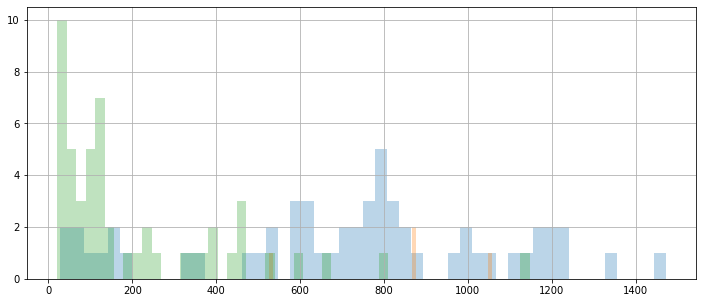

In [38]:
plant.query('1500 > mw > 20').groupby('mod_prime_mover')['mw'].hist(bins=50, histtype='stepfilled', alpha=0.3, figsize = (12,5))

mod_prime_mover
CC    AxesSubplot(0.125,0.125;0.775x0.755)
CS    AxesSubplot(0.125,0.125;0.775x0.755)
GT    AxesSubplot(0.125,0.125;0.775x0.755)
Name: heat_rate, dtype: object

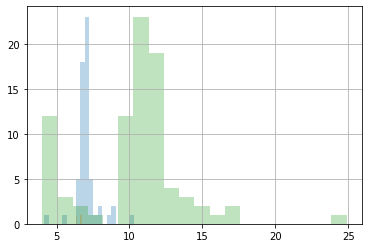

In [39]:
plant.groupby('mod_prime_mover')['heat_rate'].hist(bins=20, histtype='stepfilled', alpha=0.3)

mod_prime_mover
CC    AxesSubplot(0.125,0.125;0.775x0.755)
CS    AxesSubplot(0.125,0.125;0.775x0.755)
GT    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

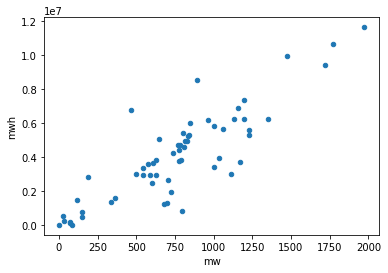

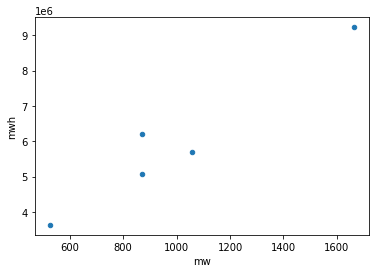

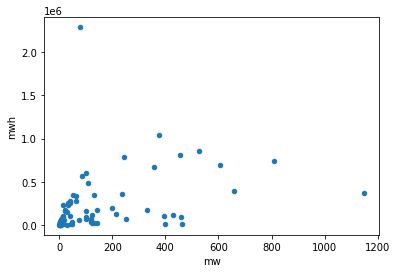

In [12]:
plant.groupby('mod_prime_mover')[['mw', 'mwh']].plot.scatter(x='mw', y='mwh')

mod_prime_mover
CC    AxesSubplot(0.125,0.125;0.775x0.755)
CS    AxesSubplot(0.125,0.125;0.775x0.755)
GT    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

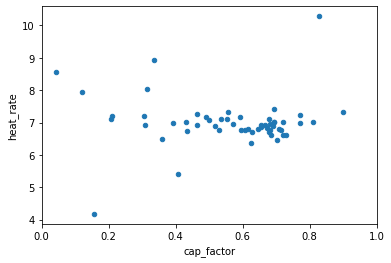

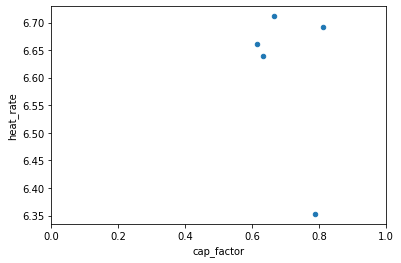

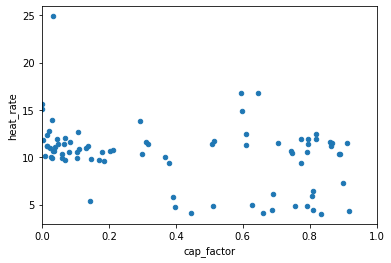

In [16]:
plant.groupby('mod_prime_mover')[['cap_factor', 'heat_rate']].plot.scatter(x='cap_factor', y='heat_rate', xlim=(0,1))

mod_prime_mover
CC    AxesSubplot(0.125,0.125;0.775x0.755)
CS    AxesSubplot(0.125,0.125;0.775x0.755)
GT    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

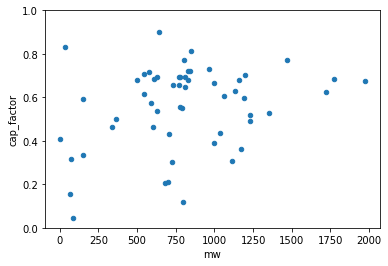

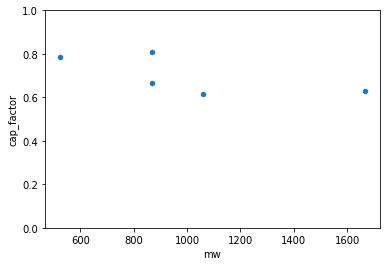

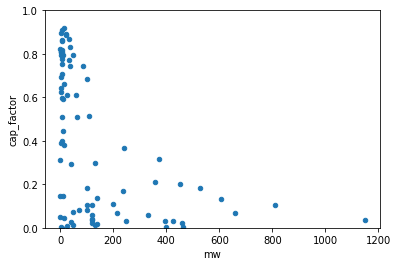

In [15]:
plant.groupby('mod_prime_mover')[['cap_factor', 'mw']].plot.scatter(y='cap_factor', x='mw', ylim=(0,1))

Estimate capacity factors. Split CC vs GT at 450 MW

<AxesSubplot:xlabel='mw'>

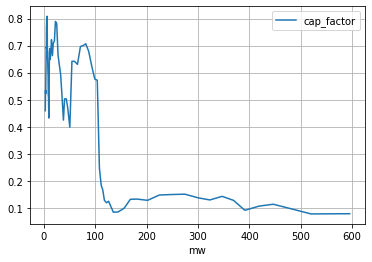

In [64]:
(plant.query('mod_prime_mover == "GT"')[['cap_factor', 'mw']]
 .sort_values('mw')
 .rolling(10).mean()
 .plot(x='mw', y='cap_factor', grid=True)
)

In [43]:
plant.query('mod_prime_mover == "CC" and mw > 450')['cap_factor'].mean()

0.6219281428674367

In [65]:
plant.query('mod_prime_mover == "GT" and 110 < mw < 450')['cap_factor'].mean()

0.10668748474014222

In [66]:
plant.query('mod_prime_mover == "GT" and mw < 110')['cap_factor'].mean()

0.6081328166567699

In [47]:
postgres_engine = get_sql_engine()

In [48]:
query = """
WITH
active_loc as (
    select
        proj.project_id,
        loc.county_id_fips
    from data_warehouse.iso_projects as proj
    left join data_warehouse.iso_locations as loc
        on loc.project_id = proj.project_id
    where proj.queue_status = 'active'
),
projects as (
    select
        loc.project_id,
        loc.county_id_fips,
        res.capacity_mw,
        res.resource_clean as resource
    from active_loc as loc
    left join data_warehouse.iso_resource_capacity as res
        on res.project_id = loc.project_id
    where res.capacity_mw is not NULL
    and res.resource_clean in ('Natural Gas', 'Coal', 'Oil')
),
w_county_names as (
select
    cfip.county_name as county,
    cfip.state_id_fips,
    proj.*
from projects as proj
left join data_warehouse.county_fips as cfip
    on proj.county_id_fips = cfip.county_id_fips
)
SELECT
    sfip.state_name as state,
    proj.*
from w_county_names as proj
left join data_warehouse.state_fips as sfip
    on proj.state_id_fips = sfip.state_id_fips
;"""
iso = pd.read_sql(query, postgres_engine)
iso.head()

,state,county,state_id_fips,project_id,county_id_fips,capacity_mw,resource
0,Washington,Grays Harbor County,53,41,53027,255.0,Natural Gas
1,Idaho,Minidoka County,16,43,16067,6.0,Natural Gas
2,Kansas,Cowley County,20,44,20035,58.0,Natural Gas
3,West Virginia,Monongalia County,54,51,54061,0.0,Natural Gas
4,Texas,Anderson County,48,54,48001,200.0,Natural Gas


<AxesSubplot:>

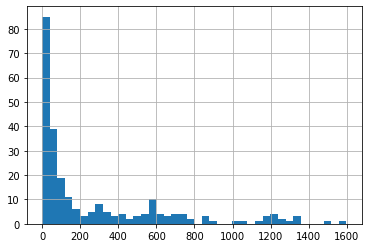

In [60]:
iso['capacity_mw'].hist(bins=40)

In [50]:
iso['capacity_mw'].mean()

263.01910569105695

In [56]:
iso['resource'].value_counts()

Natural Gas    239
Coal             7
Name: resource, dtype: int64

In [59]:
set(iso['resource'].unique()) == {'Coal', 'Natural Gas'}

True